In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchkeras import summary, Model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import warnings
from matplotlib import rcParams
from torch.utils import tensorboard

warnings.filterwarnings('ignore')
config = {
    "font.family":'Times New Roman',  # 设置字体类型
}

rcParams.update(config)

# 前言

"推荐" 对于我们来说并不陌生，已经渗透到了我们生活中的方方面面，比如淘宝的商品推荐，网易云的音乐推荐，抖音的短视频推荐等。在房产O2O领域，同样也需要推荐。无论在哪个推荐领域，推荐系统面临的一个共同挑战是如何同时满足推荐结果的准确性和多样性。<font color = "red">准确性要求推荐的内容与用户高度相关，推的精准；多样性则要求推荐内容更加新颖，让用户具有新鲜感。</font>

# 数据准备

## 预处理数据

In [2]:
train_data = pd.read_csv("../PNN模型/data/raw/train.csv")
test_data = pd.read_csv("../PNN模型//data/raw/test.csv")

train_data

,Id,Label,I1,I2,I3,I4,I5,I6,I7,I8,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,10000743,1,1.0,0,1.0,NaN,227.0,1.0,173.0,18.0,...,3486227d,e88ffc9d,c393dc22,b1252a9d,57c90cd9,NaN,bcdee96c,4d19a3eb,cb079c2d,456c12a0
1,10000159,1,4.0,1,1.0,2.0,27.0,2.0,4.0,2.0,...,07c540c4,92555263,NaN,NaN,242bb710,NaN,3a171ecb,72c78f11,NaN,NaN
2,10001166,1,0.0,806,NaN,NaN,1752.0,142.0,2.0,0.0,...,07c540c4,25c88e42,21ddcdc9,b1252a9d,a0136dd2,NaN,32c7478e,8fc66e78,001f3601,f37f3967
3,10000318,0,2.0,-1,42.0,14.0,302.0,38.0,25.0,38.0,...,e5ba7672,5aed7436,21ddcdc9,b1252a9d,c3abeb21,NaN,423fab69,1793a828,e8b83407,5cef228f
4,10000924,1,0.0,57,2.0,1.0,2891.0,2.0,35.0,1.0,...,e5ba7672,642f2610,1d1eb838,b1252a9d,1640d50b,ad3062eb,423fab69,45ab94c8,2bf691b1,c84c4aec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,10000835,0,NaN,8,1.0,1.0,43.0,NaN,0.0,1.0,...,1e88c74f,fc35e8fe,NaN,NaN,a02708ad,c9d4222a,c3dc6cef,502f2493,NaN,NaN
1595,10001216,0,8.0,2,20.0,8.0,36.0,9.0,8.0,10.0,...,e5ba7672,5aed7436,21ddcdc9,b1252a9d,eea796be,NaN,3a171ecb,1793a828,e8b83407,5cef228f
1596,10001653,0,0.0,1,2.0,12.0,4877.0,140.0,13.0,34.0,...,e5ba7672,2b0a9d11,NaN,NaN,7453e535,NaN,dbb486d7,906e72ec,NaN,NaN
1597,10000559,0,NaN,2,NaN,1.0,1972.0,NaN,0.0,1.0,...,e5ba7672,817481a8,NaN,NaN,e4244d7f,c9d4222a,c7dc6720,60efe6e6,NaN,NaN


In [3]:
test_data

,Id,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,10000405,NaN,-1,NaN,NaN,8020.0,26.0,6.0,0.0,80.0,...,e5ba7672,7119e567,1d04f4a4,b1252a9d,d5f54153,NaN,32c7478e,a9d771cd,c9f3bea7,0a47000d
1,10001189,NaN,-1,NaN,NaN,17881.0,9.0,8.0,0.0,0.0,...,e5ba7672,51369abb,NaN,NaN,d4b6b7e8,NaN,32c7478e,37821b83,NaN,NaN
2,10000674,0.0,0,2.0,13.0,2904.0,104.0,1.0,3.0,100.0,...,e5ba7672,bd17c3da,966f1c31,a458ea53,1d1393f4,ad3062eb,32c7478e,3fdb382b,010f6491,49d68486
3,10001358,0.0,1471,51.0,4.0,1573.0,63.0,1.0,4.0,13.0,...,d4bb7bd8,1f9656b8,21ddcdc9,b1252a9d,602ce342,NaN,3a171ecb,1793a828,e8b83407,70b6702c
4,10000810,0.0,16,9.0,17.0,2972.0,621.0,13.0,42.0,564.0,...,e5ba7672,87c6f83c,NaN,NaN,bf8efd4c,c9d4222a,423fab69,f96a556f,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,10001453,1.0,0,1.0,NaN,149.0,5.0,1.0,0.0,0.0,...,d4bb7bd8,5aed7436,d16737e3,a458ea53,edc49a33,NaN,93bad2c0,3fdb382b,e8b83407,80dd0a5b
396,10000360,NaN,-1,NaN,NaN,NaN,NaN,0.0,0.0,6.0,...,2005abd1,5162930e,NaN,NaN,12965bb8,NaN,32c7478e,71292dbb,NaN,NaN
397,10001809,0.0,300,4.0,NaN,4622.0,25.0,20.0,6.0,55.0,...,8efede7f,a78bd508,21ddcdc9,5840adea,c2a93b37,NaN,3a171ecb,1793a828,e8b83407,2fede552
398,10000769,1.0,1,2.0,1.0,5.0,1.0,1.0,1.0,1.0,...,d4bb7bd8,a1d0cc4f,c68db44a,a458ea53,3b1ae854,NaN,32c7478e,57e2c6c9,1575c75f,7132fed8


In [4]:
lable = train_data["Label"]
del train_data["Label"]
all_data = pd.concat([train_data, test_data])
del all_data["Id"]

In [5]:
# 整理数据
features = all_data.columns
spase_feature = [c for c in features if c[0] == "C"]  # 类别性变量
dense_feature = [c for c in features if c[0] == "I"]  # 数值性变量

# 填补缺失值
all_data[spase_feature] = all_data[spase_feature].fillna("-1")
all_data[dense_feature] = all_data[dense_feature].fillna("0")

In [6]:
# 编码特征信息
def spase_feats_info(feat, feat_num, embed_dim=4):
    """稀疏特征信息"""
    
    return {"feat": feat, "feat_num": feat_num, "embed_dim": embed_dim}

def dense_feats_info(feat):
    """稠密特征信息"""
    
    return {"feat": feat}

In [7]:
# 编码信息,可以编码为nametuble类型，
feat_info = [[dense_feats_info(feat) for feat in dense_feature]] + [[spase_feats_info(feat=feat
                                                                                      , feat_num=len(all_data[feat].unique())
                                                                                      , embed_dim=8) for feat in spase_feature]
                                                                   ]

In [8]:
np.save("./data/process/feature_info.npy", feat_info)

In [9]:
# 分类特征编码数据
for feature in spase_feature:
    le = LabelEncoder()
    le = le.fit(all_data[feature])
    all_data[feature] = le.transform(all_data[feature])

In [10]:
feat_info

[[{'feat': 'I1'},
  {'feat': 'I2'},
  {'feat': 'I3'},
  {'feat': 'I4'},
  {'feat': 'I5'},
  {'feat': 'I6'},
  {'feat': 'I7'},
  {'feat': 'I8'},
  {'feat': 'I9'},
  {'feat': 'I10'},
  {'feat': 'I11'},
  {'feat': 'I12'},
  {'feat': 'I13'}],
 [{'feat': 'C1', 'feat_num': 79, 'embed_dim': 8},
  {'feat': 'C2', 'feat_num': 252, 'embed_dim': 8},
  {'feat': 'C3', 'feat_num': 1293, 'embed_dim': 8},
  {'feat': 'C4', 'feat_num': 1043, 'embed_dim': 8},
  {'feat': 'C5', 'feat_num': 30, 'embed_dim': 8},
  {'feat': 'C6', 'feat_num': 7, 'embed_dim': 8},
  {'feat': 'C7', 'feat_num': 1164, 'embed_dim': 8},
  {'feat': 'C8', 'feat_num': 39, 'embed_dim': 8},
  {'feat': 'C9', 'feat_num': 2, 'embed_dim': 8},
  {'feat': 'C10', 'feat_num': 908, 'embed_dim': 8},
  {'feat': 'C11', 'feat_num': 926, 'embed_dim': 8},
  {'feat': 'C12', 'feat_num': 1239, 'embed_dim': 8},
  {'feat': 'C13', 'feat_num': 824, 'embed_dim': 8},
  {'feat': 'C14', 'feat_num': 20, 'embed_dim': 8},
  {'feat': 'C15', 'feat_num': 819, 'embed_dim'

In [11]:
# 数值特征归一化操作
mm = MinMaxScaler()
all_data[dense_feature] = mm.fit_transform(all_data[dense_feature])

In [12]:
train = all_data[:len(train_data)]
test_data = all_data[len(train_data):]
train["Label"] = lable
train_set, val_set = train_test_split(train, test_size=0.2, random_state=2021)

In [13]:
# 保存处理好的数据
train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)

train_set.to_csv("./data/process/train_set.csv", index=False)
val_set.to_csv("./data/process/val_set.csv", index=False)
test_data.to_csv("./data/process/test_data.csv", index=False)

## 转换数据类型

In [14]:
# 读取数据
train_set = pd.read_csv("./data/process/train_set.csv")
val_set = pd.read_csv("./data/process/val_set.csv")
test_data = pd.read_csv("./data/process/test_data.csv")
feat_info = np.load("./data/process/feature_info.npy", allow_pickle=True)

In [15]:
feat_info[0], feat_info[1]

([{'feat': 'I1'},
  {'feat': 'I2'},
  {'feat': 'I3'},
  {'feat': 'I4'},
  {'feat': 'I5'},
  {'feat': 'I6'},
  {'feat': 'I7'},
  {'feat': 'I8'},
  {'feat': 'I9'},
  {'feat': 'I10'},
  {'feat': 'I11'},
  {'feat': 'I12'},
  {'feat': 'I13'}],
 [{'feat': 'C1', 'feat_num': 79, 'embed_dim': 8},
  {'feat': 'C2', 'feat_num': 252, 'embed_dim': 8},
  {'feat': 'C3', 'feat_num': 1293, 'embed_dim': 8},
  {'feat': 'C4', 'feat_num': 1043, 'embed_dim': 8},
  {'feat': 'C5', 'feat_num': 30, 'embed_dim': 8},
  {'feat': 'C6', 'feat_num': 7, 'embed_dim': 8},
  {'feat': 'C7', 'feat_num': 1164, 'embed_dim': 8},
  {'feat': 'C8', 'feat_num': 39, 'embed_dim': 8},
  {'feat': 'C9', 'feat_num': 2, 'embed_dim': 8},
  {'feat': 'C10', 'feat_num': 908, 'embed_dim': 8},
  {'feat': 'C11', 'feat_num': 926, 'embed_dim': 8},
  {'feat': 'C12', 'feat_num': 1239, 'embed_dim': 8},
  {'feat': 'C13', 'feat_num': 824, 'embed_dim': 8},
  {'feat': 'C14', 'feat_num': 20, 'embed_dim': 8},
  {'feat': 'C15', 'feat_num': 819, 'embed_dim'

In [16]:
# 合并数据
all_data_df = pd.concat((train_set, val_set, test_data))
all_data_df

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,Label
0,0.021053,0.011442,0.000000,0.034483,0.000040,0.000647,0.014475,0.000000,0.027142,0.25,...,253,0,0,105,0,1,165,0,0,0.0
1,0.000000,0.001907,0.000000,0.011494,0.057332,0.067917,0.000000,0.001828,0.013128,0.00,...,160,0,0,316,3,0,520,0,0,0.0
2,0.000000,0.016400,0.000118,0.034483,0.001658,0.004097,0.015682,0.031079,0.084265,0.00,...,392,193,2,256,3,10,175,2,150,1.0
3,0.000000,0.000254,0.001301,0.103448,0.015978,0.192324,0.004825,0.082267,0.077524,0.00,...,390,0,0,2,0,10,163,0,0,1.0
4,0.000000,0.000127,0.000000,0.000000,0.317903,0.000000,0.000000,0.001828,0.000887,0.00,...,313,23,1,997,0,1,125,28,398,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.010526,0.000254,0.000118,0.000000,0.000147,0.001078,0.000603,0.000000,0.000000,0.25,...,188,166,2,1127,0,5,175,27,262,NaN
396,0.000000,0.000127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001064,0.00,...,172,0,0,83,0,0,333,0,0,NaN
397,0.000000,0.038393,0.000473,0.000000,0.004553,0.005390,0.012063,0.010969,0.009757,0.00,...,347,23,1,922,0,1,67,27,91,NaN
398,0.010526,0.000381,0.000236,0.011494,0.000005,0.000216,0.000603,0.001828,0.000177,0.25,...,335,155,2,287,0,0,253,3,238,NaN


In [17]:
# 取出稀疏特征，统计变量取值范围，进行Embedding
features = all_data_df.columns
spase_feature = [c for c in features if c[0] == "C"]  # 类别性变量
dense_feature = [c for c in features if c[0] == "I"]  # 数值性变量

# 统计
spase_feats_map = {}
for feature in spase_feature:
    spase_feats_map[feature] = all_data_df[feature].nunique()

# 保存
feature_info = [dense_feature, spase_feature, spase_feats_map]

In [18]:
# 准备数据, 构造dataset
train_dataset = TensorDataset(torch.tensor(train_set.drop(columns="Label").values).float()
                                 , torch.tensor(train_set["Label"].values).float()
                                )

val_dataset = TensorDataset(torch.tensor(val_set.drop(columns="Label").values).float()
                                , torch.tensor(val_set["Label"]).float()
                               )

In [19]:
train_dataloader = DataLoader(train_dataset
                              , shuffle = True
                              , batch_size = 16
                             )

val_dataloader = DataLoader(val_dataset
                             , shuffle = True
                             , batch_size = 16
                            )

In [20]:
# 看一下数据
for b in iter(train_dataloader):
    print(b[0].shape, b[1])
    break

torch.Size([16, 39]) tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


# 模型
Wide&Deep模型旨在使得训练得到的模型能够同时兼顾记忆（Memorization）与泛化（Generalization）能力：
- Memorization：模型能够从历史数据中学习到高频共现的特征组合，发掘特征之间的相关性，通过特征交叉产生特征相互作用的“记忆”，高效可解释。但要泛化，则需要更多的特征工程。
- Generalization：代表模型能够利用相关性的传递性去探索历史数据中从未出现过的特征组合，通过embedding的方法，使用低维稠密特征输入，可以更好的泛化训练样本中从未出现的交叉特征。
![](./imgs/model.png)

## Wide Part
记忆能力： 模型直接学习并利用（exploiting）历史数据中物品或特征“贡献频率”的能力。

In [21]:
class Linear(nn.Module):
    """
    记忆能力
    """
    
    def __init__(self, input_dim):
        
        super(Linear, self).__init__()
        self.linear = nn.Linear(in_features=input_dim, out_features=1)
        
    def forward(self, x):
        
        x = self.linear(x)
        
        return x

## Deep Part
泛化能力： 基于特征传递的相关性，探索（exploring）过去从未或很少发生的新特征组合。

In [22]:
class DNN(nn.Module):
    """
    泛化能力
    """
    
    def __init__(self, hidden_units, dropout = 0):
        
        super(DNN, self).__init__()
        
        self.dnn = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(p = dropout)
        
    def forward(self, x):
        
        for linear in self.dnn:
            x = linear(x)
            x = F.relu(x)
        x = self.dropout(x)
        
        return x

## Wide&Deep
==注意==:交差积变换需要人工根据业务来构建合适的特征组合形式，输入线性部分(Wide part)的特征集为：原始特征和交叉积变换后的特征,dnn部分为全量的特征数据（离散特征:Embedding，稠密特征:归一化）。  
![](./imgs/model1.png)

In [23]:
class WideDeep(nn.Module):
    
    
    def __init__(self, feature_columns, hidden_units, dropout=0.):
        
        super(WideDeep, self).__init__()
        self.dense_feature, self.spase_feature = feature_columns
        # 编码Embedding
        self.embed_layer = nn.ModuleDict({
            "embed_" + str(i): nn.Embedding(num_embeddings=feat["feat_num"], embedding_dim=feat["embed_dim"]
                                           ) for i, feat in enumerate(self.spase_feature)})
        # dnn自适应输入大小
        hidden_units.insert(0, len(self.dense_feature) + len(self.spase_feature)*self.spase_feature[0]["embed_dim"])
        self.dnn_network = DNN(hidden_units, dropout)
        self.linear_layer = Linear(len(self.dense_feature))
        self.final_linear = nn.Linear(hidden_units[-1], 1)
        
    def forward(self, x):
        
        dense_input, spase_input = x[:, :len(self.dense_feature)], x[:, len(self.dense_feature):]
        spase_input = spase_input.long()
        spase_embdes = [self.embed_layer["embed_" + str(i)](spase_input[:, i]) for i in range(spase_input.shape[1])]
        
        # 拼接所有的Embedding向量
        spase_embdes = torch.cat(spase_embdes, axis=-1)
        # Embedding向量拼接稀疏特征(dnn端输入全量的特征数据)
        dnn_input = torch.cat([spase_embdes, dense_input], axis=-1)
        
        # wide
        wide_out = self.linear_layer(dense_input)
        
        # deep
        deep_out = self.dnn_network(dnn_input)
        deep_out = self.final_linear(deep_out)
        
        # 结合
        outputs = F.sigmoid(0.5*(wide_out + deep_out))
        
        return outputs

In [24]:
hidden_units = [256, 128, 64]
hidden_units_copy = hidden_units.copy()
dnn_dropout = 0.

net = WideDeep(feat_info, hidden_units, dnn_dropout)
net

WideDeep(
  (embed_layer): ModuleDict(
    (embed_0): Embedding(79, 8)
    (embed_1): Embedding(252, 8)
    (embed_2): Embedding(1293, 8)
    (embed_3): Embedding(1043, 8)
    (embed_4): Embedding(30, 8)
    (embed_5): Embedding(7, 8)
    (embed_6): Embedding(1164, 8)
    (embed_7): Embedding(39, 8)
    (embed_8): Embedding(2, 8)
    (embed_9): Embedding(908, 8)
    (embed_10): Embedding(926, 8)
    (embed_11): Embedding(1239, 8)
    (embed_12): Embedding(824, 8)
    (embed_13): Embedding(20, 8)
    (embed_14): Embedding(819, 8)
    (embed_15): Embedding(1159, 8)
    (embed_16): Embedding(9, 8)
    (embed_17): Embedding(534, 8)
    (embed_18): Embedding(201, 8)
    (embed_19): Embedding(4, 8)
    (embed_20): Embedding(1204, 8)
    (embed_21): Embedding(7, 8)
    (embed_22): Embedding(12, 8)
    (embed_23): Embedding(729, 8)
    (embed_24): Embedding(33, 8)
    (embed_25): Embedding(554, 8)
  )
  (dnn_network): DNN(
    (dnn): ModuleList(
      (0): Linear(in_features=221, out_features=

## 联合训练
**联合训练公式**：
$$
P(Y = 1| x) = \sigma(W_{wide}^{T}[x, \phi(x)] + W^T_{deep}a^{lf} +b)　\tag{１}
$$  
其中, $\phi(x)$表示交叉积变换后的结果，如公式(2):  
[How is the cross-product transformation defined for binary features?](https://datascience.stackexchange.com/questions/57435/how-is-the-cross-product-transformation-defined-for-binary-features)
$$
\phi_k(x) = \sum^d_{i=1} x_i^{cki}　　cki\in{0, 1}\tag{２}
$$

**联合训练描述**：  
![](./imgs/joint.png)

# 训练

## 参数设定

In [25]:
# 模型的相关设置
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0001)
metric_func = auc
metric_name = 'auc'

epochs = 6
log_step_freq = 10

## Training＆Validing

In [26]:
dfhistory = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])
print('Start Training...')
nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print('========='*8 + "%s" %nowtime)

for epoch in tqdm(range(1, epochs+1)):
    # 训练阶段
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(train_dataloader, 1):
        labels = labels.unsqueeze(1)
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        predictions = net(features)
        loss = loss_func(predictions, labels)
        try:          # 这里就是如果当前批次里面的y只有一个类别， 跳过去
            metric = metric_func(predictions, labels)
        except ValueError:
            pass
        
        # 反向传播求梯度
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                  (step, loss_sum/step, metric_sum/step))
    
    # 验证阶段
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features, labels) in enumerate(val_dataloader, 1):
        labels = labels.unsqueeze(1)
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
        
print('Finished Training...')

  0%|          | 0/6 [00:00<?, ?it/s]

Start Training...
========================================================================2021-04-22 17:31:11
[step = 10] loss: 0.725, auc: 0.502
[step = 20] loss: 0.718, auc: 0.554
[step = 30] loss: 0.713, auc: 0.578
[step = 40] loss: 0.707, auc: 0.571
[step = 50] loss: 0.700, auc: 0.596
[step = 60] loss: 0.692, auc: 0.581


 17%|█▋        | 1/6 [00:01<00:07,  1.48s/it]

[step = 70] loss: 0.682, auc: 0.575
[step = 80] loss: 0.670, auc: 0.573

EPOCH = 1, loss = 0.670,auc  = 0.573, val_loss = 0.585, val_auc = 0.534

================================================================================2021-04-22 17:31:13
[step = 10] loss: 0.557, auc: 0.584
[step = 20] loss: 0.532, auc: 0.571
[step = 30] loss: 0.525, auc: 0.543
[step = 40] loss: 0.538, auc: 0.571
[step = 50] loss: 0.526, auc: 0.578
[step = 60] loss: 0.519, auc: 0.573


 33%|███▎      | 2/6 [00:02<00:05,  1.32s/it]

[step = 70] loss: 0.520, auc: 0.584
[step = 80] loss: 0.516, auc: 0.602

EPOCH = 2, loss = 0.516,auc  = 0.602, val_loss = 0.524, val_auc = 0.544

================================================================================2021-04-22 17:31:14
[step = 10] loss: 0.576, auc: 0.624
[step = 20] loss: 0.554, auc: 0.660
[step = 30] loss: 0.514, auc: 0.671
[step = 40] loss: 0.504, auc: 0.669
[step = 50] loss: 0.506, auc: 0.674
[step = 60] loss: 0.493, auc: 0.675


 50%|█████     | 3/6 [00:03<00:03,  1.20s/it]

[step = 70] loss: 0.493, auc: 0.659
[step = 80] loss: 0.494, auc: 0.661

EPOCH = 3, loss = 0.494,auc  = 0.661, val_loss = 0.519, val_auc = 0.568

================================================================================2021-04-22 17:31:15
[step = 10] loss: 0.427, auc: 0.698
[step = 20] loss: 0.451, auc: 0.665
[step = 30] loss: 0.464, auc: 0.647
[step = 40] loss: 0.471, auc: 0.677
[step = 50] loss: 0.472, auc: 0.687
[step = 60] loss: 0.482, auc: 0.680


 67%|██████▋   | 4/6 [00:04<00:02,  1.10s/it]

[step = 70] loss: 0.485, auc: 0.677
[step = 80] loss: 0.483, auc: 0.681

EPOCH = 4, loss = 0.483,auc  = 0.681, val_loss = 0.513, val_auc = 0.644

================================================================================2021-04-22 17:31:16
[step = 10] loss: 0.522, auc: 0.708
[step = 20] loss: 0.507, auc: 0.704
[step = 30] loss: 0.474, auc: 0.733
[step = 40] loss: 0.469, auc: 0.757
[step = 50] loss: 0.477, auc: 0.741
[step = 60] loss: 0.470, auc: 0.741


 83%|████████▎ | 5/6 [00:05<00:01,  1.04s/it]

[step = 70] loss: 0.473, auc: 0.733
[step = 80] loss: 0.475, auc: 0.733

EPOCH = 5, loss = 0.475,auc  = 0.733, val_loss = 0.509, val_auc = 0.633

================================================================================2021-04-22 17:31:16
[step = 10] loss: 0.433, auc: 0.771
[step = 20] loss: 0.465, auc: 0.747
[step = 30] loss: 0.477, auc: 0.734
[step = 40] loss: 0.478, auc: 0.747
[step = 50] loss: 0.472, auc: 0.757
[step = 60] loss: 0.465, auc: 0.744


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

[step = 70] loss: 0.474, auc: 0.749
[step = 80] loss: 0.465, auc: 0.757

EPOCH = 6, loss = 0.465,auc  = 0.757, val_loss = 0.506, val_auc = 0.642

================================================================================2021-04-22 17:31:17
Finished Training...


## 数据可视化

In [27]:
def plot_metric(dfhistory, metric, ax):
    """绘制评估曲线"""
    
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    ax.plot(epochs, train_metrics, 'bo--')
    ax.plot(epochs, val_metrics, 'ro-')
    ax.set_title('Training and validation '+ metric, fontsize=15)
    ax.set_xlabel("Epochs", fontsize=14)
    ax.set_ylabel(metric, fontsize=14)
    ax.legend(["train_"+metric, 'val_'+metric])
    ax.grid()

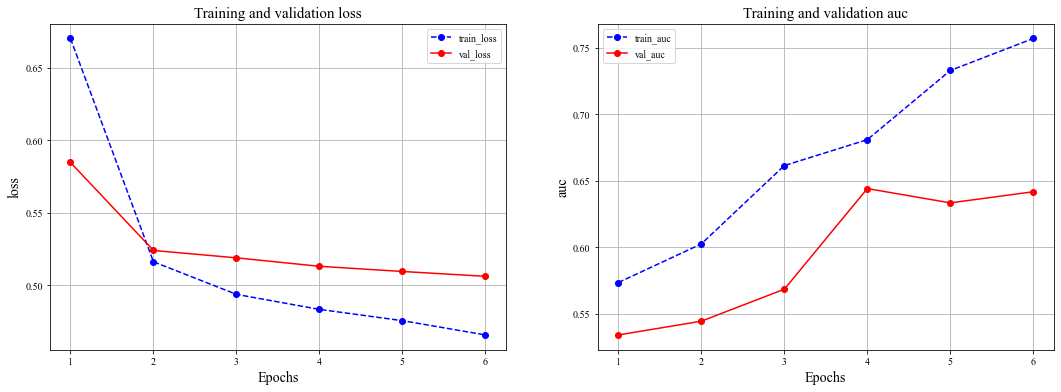

In [28]:
# 观察损失和准确率的变化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plot_metric(dfhistory,"loss", ax1)
plot_metric(dfhistory,"auc", ax2)

## 模型保存与读取

In [29]:
torch.save(net.state_dict(), f="./checkpoints/WideDeep.pkl")

In [30]:
net1 = WideDeep(feat_info,hidden_units_copy)
net1.load_state_dict(torch.load("./checkpoints/WideDeep.pkl"))

<All keys matched successfully>

In [31]:
net1

WideDeep(
  (embed_layer): ModuleDict(
    (embed_0): Embedding(79, 8)
    (embed_1): Embedding(252, 8)
    (embed_2): Embedding(1293, 8)
    (embed_3): Embedding(1043, 8)
    (embed_4): Embedding(30, 8)
    (embed_5): Embedding(7, 8)
    (embed_6): Embedding(1164, 8)
    (embed_7): Embedding(39, 8)
    (embed_8): Embedding(2, 8)
    (embed_9): Embedding(908, 8)
    (embed_10): Embedding(926, 8)
    (embed_11): Embedding(1239, 8)
    (embed_12): Embedding(824, 8)
    (embed_13): Embedding(20, 8)
    (embed_14): Embedding(819, 8)
    (embed_15): Embedding(1159, 8)
    (embed_16): Embedding(9, 8)
    (embed_17): Embedding(534, 8)
    (embed_18): Embedding(201, 8)
    (embed_19): Embedding(4, 8)
    (embed_20): Embedding(1204, 8)
    (embed_21): Embedding(7, 8)
    (embed_22): Embedding(12, 8)
    (embed_23): Embedding(729, 8)
    (embed_24): Embedding(33, 8)
    (embed_25): Embedding(554, 8)
  )
  (dnn_network): DNN(
    (dnn): ModuleList(
      (0): Linear(in_features=221, out_features=

In [32]:
# 评估测试集
probs = net1(torch.tensor(test_data.values).float())
df = pd.DataFrame(probs.data.numpy())
df[1] = df[0].apply(lambda x:1 if x>0.5 else 0)
df = df.rename(columns={0:"probs", 1:"label"})
df

,probs,label
0,0.329606,0
1,0.303071,0
2,0.354735,0
3,0.164873,0
4,0.205360,0
...,...,...
395,0.151002,0
396,0.193211,0
397,0.145197,0
398,0.305127,0


# 参考
[AI上推荐 之 Wide&Deep与Deep&Cross模型(记忆与泛化并存的华丽转身](https://blog.csdn.net/wuzhongqiang/article/details/109254498#t9)  
[见微知著，你真的搞懂Google的Wide&Deep模型了吗？](https://zhuanlan.zhihu.com/p/142958834)  
[详解 Wide & Deep 结构背后的动机](https://zhuanlan.zhihu.com/p/53361519)  
[wide&deep 在贝壳推荐场景的实践](https://mp.weixin.qq.com/s?__biz=MzI2ODA3NjcwMw==&mid=2247483659&idx=1&sn=deb9c5e22eabd3c52d2418150a40c68a&scene=21#wechat_redirect)  
[Wide&Deep模型的八个实战细节](https://www.zhuanzhi.ai/document/782d439e23f5751caded8d9e1e18dd16)  
[计算广告CTR预估系列(四)--Wide&Deep理论与实践](https://mp.weixin.qq.com/s?src=11&timestamp=1616937844&ver=2974&signature=cruWB0B-SfCJGo6xY2f9--asIvID6PoOzZbdCfdI7A5pLnjACvcD8cm6y**HYNer-IQioYhB*HzeIZ82jqlUWN5h-dNhSQPq4jqd3agIJf8KNQKy0tdY1tmOX9do28Dm&new=1)  